# **Tidying**

Part of the data engineering process is data cleaning and tidying. What is done in those two processes, is trying to make the data more readable, and complete. This makes much easier to analyze, visualize, and train the data.


## **Data Tidying**

Making the data more organized, and readable is the result of applying data tidying. 

In this section two main pandas functions are used in data tidying those are `melt` and `pivot_table`.

Let's start by taking a look at the below dataframe, which represents the income ranges based on religion. This is part of the PEW research, which is famous in the US for conducting pollings and surveys on citizens.

When the following are satisfied:


1. Each variable forms a column
2. Each observation forms a row
3. Each type of observational unit forms a table

We can then say that our dataset is *tidy*.

First we need to import pandas to read csv datasets.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns # Added seaborn for better visualization
from scipy import stats


### **PEW Research Dataset**

1. Start by Importing the dataset into a pandas dataframe.

2. Observe the dataset using the `loc`, `iloc`, `head`, or `tail` approaches

***What does not seem right in the above dataframe?***

3. Try to make the column headers represent a variable not a value. For that, use the `melt` function.

In [217]:
pew_csvFile = 'data/pew-raw.csv'
pew_dataFrame = pd.read_csv(pew_csvFile)

#use of loc() function to access a group of rows and columns by labels or a boolean array
pew_loc = pew_dataFrame.loc()
print("\nUsing loc() function:")
print(pew_loc)

#use of iloc() function to access a group of rows and columns by integer position(s)
pew_iloc = pew_dataFrame.iloc()
print("\nUsing iloc() function:")
print(pew_iloc)

#use of head() function to view the first few rows of the DataFrame
pew_head = pew_dataFrame.head(4)
print("\nUsing head() function:")
print(pew_head)

#use of tail() function to view the last few rows of the DataFrame 
pew_tail = pew_dataFrame.tail(3)
print("\nUsing tail() function:")
print(pew_tail)

#use of melt() function to transform the DataFrame from wide format to long format
# pd.melt(
#     frame,               # your DataFrame
#     id_vars=None,        # columns to keep fixed (like identifiers)
#     value_vars=None,     # columns to unpivot (optional)
#     var_name=None,       # name for the new 'variable' column
#     value_name='value'   # name for the new 'value' column
# )
melted = pd.melt(pew_dataFrame,
                id_vars='religion',
                var_name='income_bracket',
                value_name='count')
print("\nUsing melt() function:")
print(melted)



Using loc() function:

Using iloc() function:

Using head() function:
   religion   <$10k   $10-20k  $20-30k  $30-40k   $40-50k  $50-75k
0  Agnostic      27        34       60       81        76      137
1   Atheist      12        27       37       52        35       70
2  Buddhist      27        21       30       34        33       58
3  Catholic     418       617      732      670       638     1116

Using tail() function:
                   religion   <$10k   $10-20k  $20-30k  $30-40k   $40-50k  \
7  Historically Black Prot      228       244      236      238       197   
8         Jehovahs Witness       20        27       24       24        21   
9                   Jewish       19        19       25       25        30   

   $50-75k  
7      223  
8       30  
9       95  

Using melt() function:
                    religion income_bracket  count
0                   Agnostic          <$10k     27
1                    Atheist          <$10k     12
2                   Buddhist    

### **Billboard Dataset**

This dataset outlines data about the top hit songs on the Billboard list and the week from entrance that it was in the billboard with the ranking.

1. Read the dataset and store it in a pandas dataframe. Note that the usual utf-8 encoding does not work on this dataset. The reason behind this is that there might be characters that are not supported by `utf-8`.

The suggestion is to use for this dataset `unicode_escape` encoding. (converts all non-ASCII characters into their \uXXXX representations)

In [218]:
billboard_csvFile = 'data/billboard.csv'
# file was enocoded in utf-8 format use encoding='unicode_escape' will help in handle the csv file
# pd.read_csv(filepath_or_buffer, encoding=None, ...)
billboard_dataFrame = pd.read_csv(billboard_csvFile, encoding='unicode_escape')
# above encoding will help in handling special characters in the csv file

2. Observe the first few rows of the dataset.

In [219]:
# use of head() function to view the first few rows of the DataFrame
print(billboard_dataFrame.head(5))

   year      artist.inverted                                  track  time  \
0  2000      Destiny's Child               Independent Women Part I  3:38   
1  2000              Santana                           Maria, Maria  4:18   
2  2000        Savage Garden                     I Knew I Loved You  4:07   
3  2000              Madonna                                  Music  3:45   
4  2000  Aguilera, Christina  Come On Over Baby (All I Want Is You)  3:38   

  genre date.entered date.peaked  x1st.week  x2nd.week  x3rd.week  ...  \
0  Rock   2000-09-23  2000-11-18         78       63.0       49.0  ...   
1  Rock   2000-02-12  2000-04-08         15        8.0        6.0  ...   
2  Rock   1999-10-23  2000-01-29         71       48.0       43.0  ...   
3  Rock   2000-08-12  2000-09-16         41       23.0       18.0  ...   
4  Rock   2000-08-05  2000-10-14         57       47.0       45.0  ...   

   x67th.week  x68th.week  x69th.week  x70th.week  x71st.week  x72nd.week  \
0         NaN  

***What is wrong with the above dataset?***

3. Let's, again, use the `melt` function to fix the general structure of the dataframe.

In [220]:
# Convert all the week columns in Week column
# Identify all the week columns
# Create a list of all week columns
# Use list comprehension to filter columns that start with 'x' and contain 'week'
# Example: ['x1.week', 'x2.week', ..., 'x76.week']
weekly_cols = [col for col in billboard_dataFrame.columns if col.startswith('x') and 'week' in col]

df_melted = pd.melt(billboard_dataFrame,
            id_vars=['year', 
                    'artist.inverted', 
                    'track', 
                    'genre', 
                    'date.entered', 
                    'date.peaked', 
                    'time'],
            value_vars=weekly_cols,
            var_name='week',
            value_name='chart_position')

print(df_melted.head())

   year      artist.inverted                                  track genre  \
0  2000      Destiny's Child               Independent Women Part I  Rock   
1  2000              Santana                           Maria, Maria  Rock   
2  2000        Savage Garden                     I Knew I Loved You  Rock   
3  2000              Madonna                                  Music  Rock   
4  2000  Aguilera, Christina  Come On Over Baby (All I Want Is You)  Rock   

  date.entered date.peaked  time       week  chart_position  
0   2000-09-23  2000-11-18  3:38  x1st.week            78.0  
1   2000-02-12  2000-04-08  4:18  x1st.week            15.0  
2   1999-10-23  2000-01-29  4:07  x1st.week            71.0  
3   2000-08-12  2000-09-16  3:45  x1st.week            41.0  
4   2000-08-05  2000-10-14  3:38  x1st.week            57.0  


If we inspect the current dataframe. We find that it is structured in a better way than before. 

However, the ***Week*** column looks a bit ugly!

4. Let's try to place only the week number in that column without the extras surronding it.

In [221]:
# weekly_cols = [col for col in billboard_dataFrame.columns if col.startswith('x') and 'week' in col]

# df_melted = pd.melt(billboard_dataFrame,
#                     id_vars=['year', 'artist.inverted', 'track', 'genre', 'date.entered', 'date.peaked'],
#                     value_vars=weekly_cols,
#                     var_name='week',
#                     value_name='chart_position')

# Extract numeric week number from 'week' column
# Convert 'week' column to numeric values by extracting the number from the string
# Use str.extract() to get the numeric part and convert to integer
# Example: 'x1.week' -> 1, 'x2.week' -> 2, ..., 'x76.week' -> 76
# astype(int) converts the extracted string to integer type
df_melted['week'] = df_melted['week'].str.extract(r'(\d+)').astype(int)
print(df_melted)

       year      artist.inverted                                  track genre  \
0      2000      Destiny's Child               Independent Women Part I  Rock   
1      2000              Santana                           Maria, Maria  Rock   
2      2000        Savage Garden                     I Knew I Loved You  Rock   
3      2000              Madonna                                  Music  Rock   
4      2000  Aguilera, Christina  Come On Over Baby (All I Want Is You)  Rock   
...     ...                  ...                                    ...   ...   
24087  2000     Ghostface Killah                       Cherchez LaGhost   R&B   
24088  2000          Smith, Will                            Freakin' It   Rap   
24089  2000        Zombie Nation                          Kernkraft 400  Rock   
24090  2000       Eastsidaz, The                               Got Beef   Rap   
24091  2000               Fragma                         Toca's Miracle   R&B   

      date.entered date.pea

5. Now let's inspect the ***Week*** column in the dataframe.

Next, let's try to find the date at which the song ranked the number that is shown per row.

6. To do that let's first think of the equation that is going to get us the relevant date at which the song ranked the *rth*.



In [222]:
# Ensure date.entered is datetime type
# Convert 'date.entered' column to datetime format for proper date handling
# Use pd.to_datetime() to convert the column
# This ensures that date operations can be performed on this column
df_melted['date.entered'] = pd.to_datetime(df_melted['date.entered'])
df_melted


,year,artist.inverted,track,genre,date.entered,date.peaked,time,week,chart_position
0,2000,Destiny's Child,Independent Women Part I,Rock,2000-09-23,2000-11-18,3:38,1,78.0
1,2000,Santana,"Maria, Maria",Rock,2000-02-12,2000-04-08,4:18,1,15.0
2,2000,Savage Garden,I Knew I Loved You,Rock,1999-10-23,2000-01-29,4:07,1,71.0
3,2000,Madonna,Music,Rock,2000-08-12,2000-09-16,3:45,1,41.0
4,2000,"Aguilera, Christina",Come On Over Baby (All I Want Is You),Rock,2000-08-05,2000-10-14,3:38,1,57.0
...,...,...,...,...,...,...,...,...,...
24087,2000,Ghostface Killah,Cherchez LaGhost,R&B,2000-08-05,2000-08-05,3:04,76,NaN
24088,2000,"Smith, Will",Freakin' It,Rap,2000-02-12,2000-02-12,3:58,76,NaN
24089,2000,Zombie Nation,Kernkraft 400,Rock,2000-09-02,2000-09-02,3:30,76,NaN
24090,2000,"Eastsidaz, The",Got Beef,Rap,2000-07-01,2000-07-01,3:58,76,NaN


*Timedeltas are absolute differences in times, expressed in difference units (e.g. days, hours, minutes, seconds). This method converts an argument from a recognized timedelta format / value into a Timedelta type.*


In [223]:
# Calculate the actual chart date for each entry
# Use the 'date.entered' and 'week' columns to calculate the actual date for each chart position
# pd.to_timedelta() is used to convert weeks into a timedelta object
# The formula adds (week - 1) * 7 days to the 'date.entered' to get the actual chart date
# This gives the exact date when the song was at that chart position
df_melted['chart_date'] = df_melted['date.entered'] + pd.to_timedelta(df_melted['week'] - 1, unit='D') * 7

df_melted

,year,artist.inverted,track,genre,date.entered,date.peaked,time,week,chart_position,chart_date
0,2000,Destiny's Child,Independent Women Part I,Rock,2000-09-23,2000-11-18,3:38,1,78.0,2000-09-23
1,2000,Santana,"Maria, Maria",Rock,2000-02-12,2000-04-08,4:18,1,15.0,2000-02-12
2,2000,Savage Garden,I Knew I Loved You,Rock,1999-10-23,2000-01-29,4:07,1,71.0,1999-10-23
3,2000,Madonna,Music,Rock,2000-08-12,2000-09-16,3:45,1,41.0,2000-08-12
4,2000,"Aguilera, Christina",Come On Over Baby (All I Want Is You),Rock,2000-08-05,2000-10-14,3:38,1,57.0,2000-08-05
...,...,...,...,...,...,...,...,...,...,...
24087,2000,Ghostface Killah,Cherchez LaGhost,R&B,2000-08-05,2000-08-05,3:04,76,NaN,2002-01-12
24088,2000,"Smith, Will",Freakin' It,Rap,2000-02-12,2000-02-12,3:58,76,NaN,2001-07-21
24089,2000,Zombie Nation,Kernkraft 400,Rock,2000-09-02,2000-09-02,3:30,76,NaN,2002-02-09
24090,2000,"Eastsidaz, The",Got Beef,Rap,2000-07-01,2000-07-01,3:58,76,NaN,2001-12-08


***What is the problem with the calculation above?***

7. Let's only keep necessary columns

In [224]:
# Select and reorder relevant columns for final output
# Create a new DataFrame with only the relevant columns in a specific order
# This makes it easier to analyze and visualize the data
# The 'chart_date' column is included to provide context for each chart position
# The 'week' column indicates the specific week of the chart
# The final DataFrame includes:
# 'artist.inverted': Name of the artist
# 'track': Name of the track
# 'genre': Genre of the track
# 'chart_position': Position of the track on the chart
# 'week': Week number on the chart
# 'chart_date': Actual date corresponding to the chart position
df_final = df_melted[[
    'artist.inverted',
    'track',
    'genre',
    'chart_position',
    'week',
    'chart_date'
]]

df_final

,artist.inverted,track,genre,chart_position,week,chart_date
0,Destiny's Child,Independent Women Part I,Rock,78.0,1,2000-09-23
1,Santana,"Maria, Maria",Rock,15.0,1,2000-02-12
2,Savage Garden,I Knew I Loved You,Rock,71.0,1,1999-10-23
3,Madonna,Music,Rock,41.0,1,2000-08-12
4,"Aguilera, Christina",Come On Over Baby (All I Want Is You),Rock,57.0,1,2000-08-05
...,...,...,...,...,...,...
24087,Ghostface Killah,Cherchez LaGhost,R&B,NaN,76,2002-01-12
24088,"Smith, Will",Freakin' It,Rap,NaN,76,2001-07-21
24089,Zombie Nation,Kernkraft 400,Rock,NaN,76,2002-02-09
24090,"Eastsidaz, The",Got Beef,Rap,NaN,76,2001-12-08


8. How to rename your columns?

In [225]:
# Rename columns for clarity
# Rename columns to more user-friendly names
# This improves readability and understanding of the DataFrame
# The new column names are:
# 'artist': Name of the artist
# 'title': Name of the track
# 'genre': Genre of the track
# 'rank': Position of the track on the chart
# 'week_number': Week number on the chart
# 'date': Actual date corresponding to the chart position
# The renaming is done using the rename() method with a dictionary mapping old names to new names
df_renamed = df_final.rename(columns={
    'artist.inverted': 'artist',
    'track': 'title',
    'genre': 'genre',
    'chart_position': 'rank',
    'week': 'week_number',
    'chart_date': 'date'
})

df_renamed

,artist,title,genre,rank,week_number,date
0,Destiny's Child,Independent Women Part I,Rock,78.0,1,2000-09-23
1,Santana,"Maria, Maria",Rock,15.0,1,2000-02-12
2,Savage Garden,I Knew I Loved You,Rock,71.0,1,1999-10-23
3,Madonna,Music,Rock,41.0,1,2000-08-12
4,"Aguilera, Christina",Come On Over Baby (All I Want Is You),Rock,57.0,1,2000-08-05
...,...,...,...,...,...,...
24087,Ghostface Killah,Cherchez LaGhost,R&B,NaN,76,2002-01-12
24088,"Smith, Will",Freakin' It,Rap,NaN,76,2001-07-21
24089,Zombie Nation,Kernkraft 400,Rock,NaN,76,2002-02-09
24090,"Eastsidaz, The",Got Beef,Rap,NaN,76,2001-12-08


Display the dataframe

In the above dataframe, there are some *NaN* values. What are we going to do? <br/>
9. Apply quick data cleaning and then observe the dataset

## **Data Cleaning**

Data cleaning involves removing unwanted characters, imputing, or dropping missing values.

The decision is based on the dataset you have, and the information you can extract from the other columns.


Examples of data cleaning include cleaning:

1.   **Missing Data**
2.   **Irregular Data** (Outliers)
3.   **Unnecessary Data** — Repetitive Data, Duplicates and more
4.   **Inconsistent Data** — Capitalization, Addresses and more








### **Cars Data Set**

Start by reading the dataset related to car models: ./CSVs/cars.csv

In [226]:
#code to read csv file from /data/cars.csv
cars_csvPath = "data/cars.csv"
#read using and load the file as dataframe as df
# cars_dataFrame = pd.read_csv(cars_csvPath, sep=';', na_values=['', '?', 'NA', 'null'])
# sep=';' specifies that the delimiter in the CSV file is a semicolon
# na_values=['', '?', 'NA', 'null'] specifies additional strings to recognize as NaN
# This helps in handling missing or invalid data in the CSV file
cars_dataFrame = pd.read_csv(cars_csvPath, sep=';', na_values=['', '?', 'NA', 'null'])
cars_dataFrame

,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin
0,STRING,DOUBLE,INT,DOUBLE,DOUBLE,DOUBLE,DOUBLE,INT,CAT
1,Chevrolet Chevelle Malibu,NaN,8,307.0,130.0,3504.,12.0,70,US
2,Buick Skylark 320,15.0,8,350.0,NaN,3693.,11.5,70,US
3,Plymouth Satellite,NaN,8,318.0,150.0,3436.,11.0,70,US
4,AMC Rebel SST,16.0,8,NaN,150.0,NaN,12.0,70,US
...,...,...,...,...,...,...,...,...,...
402,Ford Mustang GL,27.0,4,140.0,86.00,2790.,15.6,82,US
403,Volkswagen Pickup,44.0,4,97.00,52.00,2130.,24.6,82,Europe
404,Dodge Rampage,32.0,4,135.0,84.00,2295.,11.6,82,US
405,Ford Ranger,28.0,4,120.0,79.00,2625.,18.6,82,US


First Row seems to be the datatype, we need to remove it

In [227]:
# Remove the first row if it contains metadata or unwanted information
# Use iloc to select all rows except the first one (index 0)
# reset_index(drop=True) is used to reset the index of the DataFrame after dropping the first row
# drop=True ensures that the old index is not added as a new column
# This is useful when the first row contains headers or notes that are not part of the actual data
cars_dataFrame = cars_dataFrame.iloc[1:].reset_index(drop=True)
# OR cars_dataFrame = cars_dataFrame.drop(index=0).reset_index(drop=True)
cars_dataFrame

,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin
0,Chevrolet Chevelle Malibu,NaN,8,307.0,130.0,3504.,12.0,70,US
1,Buick Skylark 320,15.0,8,350.0,NaN,3693.,11.5,70,US
2,Plymouth Satellite,NaN,8,318.0,150.0,3436.,11.0,70,US
3,AMC Rebel SST,16.0,8,NaN,150.0,NaN,12.0,70,US
4,Ford Torino,17.0,8,302.0,140.0,3449.,10.5,70,US
...,...,...,...,...,...,...,...,...,...
401,Ford Mustang GL,27.0,4,140.0,86.00,2790.,15.6,82,US
402,Volkswagen Pickup,44.0,4,97.00,52.00,2130.,24.6,82,Europe
403,Dodge Rampage,32.0,4,135.0,84.00,2295.,11.6,82,US
404,Ford Ranger,28.0,4,120.0,79.00,2625.,18.6,82,US


Let's observe the columns with null values.  Either by using the `isnull().sum()` function 

In [228]:
# if any cell is missing the data we need to show but after getting 0 as answer, using this code
# for making it sure any  '', '?', 'NA', 'null' is also a missing data
cars_dataFrame.replace(['', '?', 'NA', 'null'], pd.NA, inplace=True)


# Check columns with null values
# isnull() checks for missing values in the DataFrame
# sum() aggregates the count of missing values for each column
# reset_index() converts the Series to a DataFrame for better readability
# The resulting DataFrame has two columns: 'Column_Name' and 'Missing_Data'
missing_report = cars_dataFrame.isnull().sum().reset_index()
missing_report.columns = ['Column_Name', 'Missing_Data']
print(missing_report)

    Column_Name  Missing_Data
0           Car             0
1           MPG             3
2     Cylinders             0
3  Displacement             1
4    Horsepower             2
5        Weight             1
6  Acceleration             0
7         Model             0
8        Origin             0


There aren't many missing values. Let's take a glimpse at the percentage of the missing values:

**HINT:** We'll need `Numpy` for the below task.

In [ ]:
# Calculate percentage of missing values for each column
# isnull() checks for missing values in the DataFrame
# sum() aggregates the count of missing values for each column
# Dividing by len(cars_dataFrame) gives the proportion of missing values
# Multiplying by 100 converts the proportion to a percentage
# np.round(..., 2) rounds the percentage to 2 decimal places for better readability
missing_percent = cars_dataFrame.isnull().sum() / len(cars_dataFrame) * 100
missing_report = pd.DataFrame({
    'column_name': cars_dataFrame.columns,
    'missing_percent': np.round(missing_percent.values, 2)
})

print(missing_report)

    column_name  missing_percent
0           Car             0.00
1           MPG             0.74
2     Cylinders             0.00
3  Displacement             0.25
4    Horsepower             0.49
5        Weight             0.25
6  Acceleration             0.00
7         Model             0.00
8        Origin             0.00


Around *0.19%* of the values are missing, which isn't a lot. Therefore, we might go with the option of dropping all the rows with null values.

Lets also check dropping the columns

Let's observe how many columns we lost

### **Cars Dataset - Filling in missing values automatically**

Another option is to try and fill in the missing values through imputations.

Let's take the `MPG` column for example. We can fill in the missing values with 0s through the following line of code:

`df_cars.fillna(0) `. 

However, this does not make much sense as there isn't MPG equal to 0. How about we plot the MPG column and if it follows a random distribution we can use the mean of the column to compute the missing values. Otherwise, we can use the median (if there is a skewed normal distribution). However, there might be a better way of imputation which is getting the median or the mean of the MPG of the cars with similar attributes.

In [230]:
# Fill missing values in 'MPG' in cars_dataFrame as 0
# Use fillna() to replace NaN values in the 'MPG' column with 0
# inplace=True modifies the DataFrame in place without returning a new object
# This means that cars_dataFrame will be updated directly
cars_dataFrame.fillna({'MPG': 0}, inplace=True)
# Print the updated DataFrame to verify that missing values in 'MPG' have been filled with 0
print(cars_dataFrame)

                           Car   MPG Cylinders Displacement Horsepower Weight  \
0    Chevrolet Chevelle Malibu     0         8        307.0      130.0  3504.   
1            Buick Skylark 320  15.0         8        350.0        NaN  3693.   
2           Plymouth Satellite     0         8        318.0      150.0  3436.   
3                AMC Rebel SST  16.0         8          NaN      150.0    NaN   
4                  Ford Torino  17.0         8        302.0      140.0  3449.   
..                         ...   ...       ...          ...        ...    ...   
401            Ford Mustang GL  27.0         4        140.0      86.00  2790.   
402          Volkswagen Pickup  44.0         4        97.00      52.00  2130.   
403              Dodge Rampage  32.0         4        135.0      84.00  2295.   
404                Ford Ranger  28.0         4        120.0      79.00  2625.   
405                 Chevy S-10  31.0         4        119.0      82.00  2720.   

    Acceleration Model  Ori

If we observe the graph above, we can consider it in a way or another normally distributed. Therefore, we can impute the missing values using the mean.

To compute the mean we need numeric values. However the values in the dataframe are objects. Therefore, we need to change them to numerics so that we can compute them.

Now let's see what is the mean of the MPG column

In [235]:
# Let's see Mean of MPG
# mean() calculates the average of the 'MPG' column, ignoring NaN values
mean_mpg = cars_dataFrame['MPG'].mean()
print(f"Mean MPG: {mean_mpg}")

Mean MPG: 22.925615763546798


We can use this mean to compute the missing values since the graph demonstarted a normal distribution

### **Car Dataset - Simple Imputer**

*SimpleImputer* is a `scikit-learn` class which is helpful in handling the missing data in the predictive model dataset. It replaces the `NaN` values with a specified placeholder.
It is implemented by the use of the `SimpleImputer()` method which takes the following arguments :

`missing_values` : The missing_values placeholder which has to be imputed. By default is NaN

`strategy` : The data which will replace the NaN values from the dataset. The strategy argument can take the values – ‘mean'(default), ‘median’, ‘most_frequent’ and ‘constant’.


Let's start by importing the `SimpleImputer` into our notebook

What we need to do are two essential steps:

1. fit the data (compute the mean / median / most freq)
2. transform the data (place the computed values in the NaN cells)

In [ ]:
# Simple Imputer

imputer = SimpleImputer(strategy='mean')
# Fit the imputer on the DataFrame
imputer.fit(cars_dataFrame[['Weight', 'MPG']])
# Transform the DataFrame to fill missing values
cars_dataFrame[['Weight', 'MPG']] = imputer.transform(cars_dataFrame[['Weight', 'MPG']])
# Transform the DataFrame to fill missing values
cars_dataFrame[['Weight', 'MPG']] = imputer.transform(cars_dataFrame[['Weight', 'MPG']])
cars_dataFrame
#!/usr/bin/env python3


,Car,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model,Origin
0,Chevrolet Chevelle Malibu,0.0,8,307.0,130.0,3504.000000,12.0,70,US
1,Buick Skylark 320,15.0,8,350.0,NaN,3693.000000,11.5,70,US
2,Plymouth Satellite,0.0,8,318.0,150.0,3436.000000,11.0,70,US
3,AMC Rebel SST,16.0,8,NaN,150.0,2978.293827,12.0,70,US
4,Ford Torino,17.0,8,302.0,140.0,3449.000000,10.5,70,US
...,...,...,...,...,...,...,...,...,...
401,Ford Mustang GL,27.0,4,140.0,86.00,2790.000000,15.6,82,US
402,Volkswagen Pickup,44.0,4,97.00,52.00,2130.000000,24.6,82,Europe
403,Dodge Rampage,32.0,4,135.0,84.00,2295.000000,11.6,82,US
404,Ford Ranger,28.0,4,120.0,79.00,2625.000000,18.6,82,US


## **Outlier Detection** 


An Outlier is a data-item/object that deviates significantly from the rest of the (so-called normal)objects. They can be caused by measurement or execution errors. The analysis for outlier detection is referred to as outlier mining. There are many ways to detect the outliers, and the removal process is the data frame same as removing a data item from the panda’s data frame.



https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/





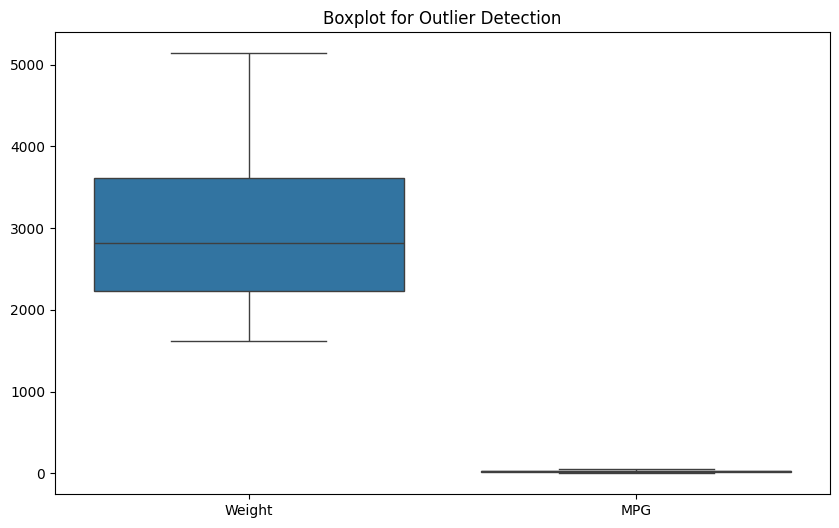

In [ ]:
#Outlier Detection and Removal
# from cars_dataFrame we will use Weight and MPG columns for outlier detection
# different methods are there for outlier detection
# Boxplot method
      

plt.figure(figsize=(10, 6)) 
# Using seaborn to create a boxplot
sns.boxplot(data=cars_dataFrame[['Weight', 'MPG']])
plt.title('Boxplot for Outlier Detection')
plt.show()

### Outliers Visualization

#### Visualizing Outliers Using Box Plot
It captures the summary of the data effectively and efficiently with only a simple box and whiskers. Boxplot summarizes sample data using 25th, 50th, and 75th percentiles. One can just get insights(quartiles, median, and outliers) into the dataset by just looking at its boxplot.

<Axes: >

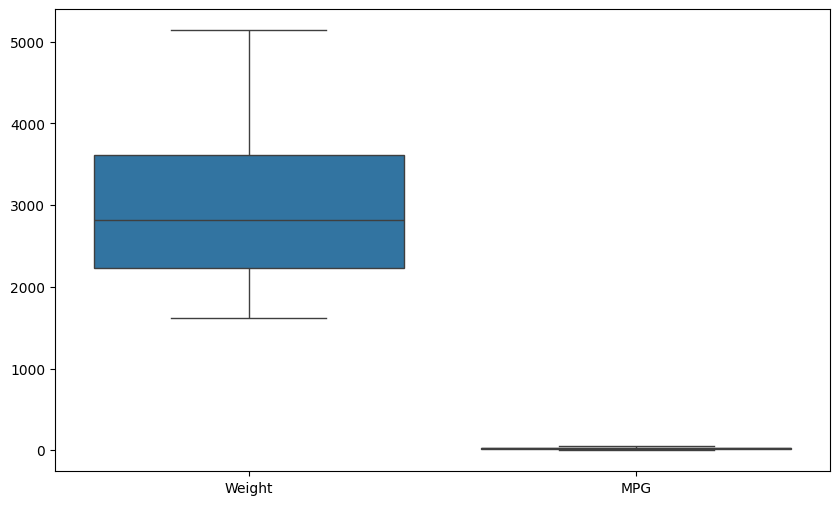

In [ ]:
# Boxplot method
# Using seaborn to create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=cars_dataFrame[['Weight', 'MPG']])

#### Visualizing Outliers Using ScatterPlot.

It is used when you have paired numerical data and when your dependent variable has multiple values for each reading independent variable, or when trying to determine the relationship between the two variables. In the process of utilizing the scatter plot, one can also use it for outlier detection.

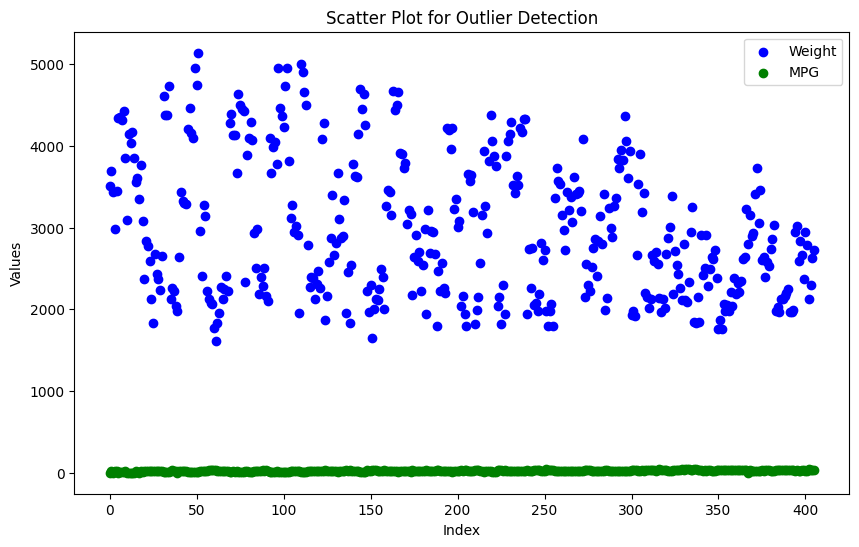

In [236]:
# Visualization Outlier using Scatter Plot
    
plt.figure(figsize=(10, 6))
plt.scatter(cars_dataFrame.index, cars_dataFrame['Weight'], color='blue', label='Weight')
plt.scatter(cars_dataFrame.index, cars_dataFrame['MPG'], color='green', label='MPG')
plt.title('Scatter Plot for Outlier Detection')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.show()



#### Z-Score:
Z- Score is also called a standard score. This value/score helps to understand that how far is the data point from the mean. And after setting up a threshold value one can utilize z score values of data points to define the outliers.
<br>
Zscore = (data_point -mean) / std. deviation



Now to define an outlier threshold value is chosen which is generally 3.0. As 99.7% of the data points lie between +/- 3 standard deviation (using Gaussian Distribution approach).

Rows where Z value is greater than 2

#### IQR (Inter-Quartile Range)
Inter Quartile Range approach to finding the outliers is the most commonly used and most trusted approach used in the research field. <Br>
IQR = Quartile3 - Quartile1

To define the outlier base value is defined above and below dataset’s normal range namely Upper and Lower bounds, define the upper and the lower bound (1.5*IQR value is considered) :<br>
upper = Q3 + 1.5 * IQR <br>
lower = Q1 - 1.5 * IQR <br> 

- Removing the outliers:
For removing the outlier, one must follow the same process of removing an entry from the dataset using its exact position in the dataset because in all the above methods of detecting the outliers end result is the list of all those data items that satisfy the outlier definition according to the method used.